In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)

In [3]:
#out = {}
out_support = {}

In [4]:
COL_info_detail = ["itemsets", "support", "tn", "fp", "fn", "tp"]

COL_info = ["itemsets", "support"]

# Parameters

In [5]:
K=3

metric = "d_fpr"
t_value_col = "t_value_fp"

min_sup_divergence=0.05

In [6]:
name_output_dir = "output_compas"

In [7]:
saveFig = False
show_fig = False

# Dataset

In [8]:
abbreviations = {
    "age_cat": "age",
    "priors_count": "#prior",
    "Greater than 45": ">45",
    "25 - 45": "25-45",
    "African-American": "Afr-Am",
    "c_charge_degree": "charge",
    "Less than 25": "<25",
    "=>": ">",
    "=<": "<",
    "length_of_stay": "stay",
    "Caucasian": "Cauc",
}

dataset_name = "compas"
risk_class_type = True

from import_datasets import import_process_compas

dfI, class_map = import_process_compas(
    risk_class=risk_class_type, continuous_col=True
)
dfI.reset_index(drop=True, inplace=True)

dfI["predicted"] = dfI["predicted"].replace({"Medium-Low": 0, "High": 1})
true_class_name, pred_class_name = "class", "predicted"
class_and_pred_names = [true_class_name, pred_class_name]
attributes = list(dfI.columns.drop(class_and_pred_names))

dfI = dfI[attributes + class_and_pred_names]
dfI.head()

,c_charge_degree,race,sex,age,priors_count,length_of_stay,class,predicted
0,F,Other,Male,69,0,1.0,0,0
1,F,African-American,Male,34,0,10.0,1,0
2,F,African-American,Male,24,4,1.0,1,0
3,M,Other,Male,44,0,1.0,0,0
4,F,Caucasian,Male,41,14,6.0,1,0


# Tree divergence - error

In [375]:
min_support_tree = 0.1

In [376]:
import os


tree_outputdir = os.path.join(".", "output", "figures", "compas", "tree")
if saveFig:
    from pathlib import Path

    Path(tree_outputdir).mkdir(parents=True, exist_ok=True)

In [377]:
cols_c = ["class", "predicted"]
continuous_attributes = ["priors_count", "length_of_stay", "age"]

In [378]:
type_experiment = "one_at_time"

In [379]:
input_attributes = ['priors_count']

In [69]:
df_analyze = dfI.copy()
df_analyze = df_analyze[input_attributes + cols_c]

## Entropy

In [380]:
metric = 'd_error'
metric, min_support_tree

('d_error', 0.1)

In [381]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=min_support_tree,
    metric=metric,
    class_map=class_map,
    continuous_attributes=input_attributes,
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion='entropy', #type_criterion,
    minimal_gain = None
)

In [382]:
generalization_dict

{'priors_count': {'[1-2]': '>=1',
  '1': '[1-2]',
  '2': '[1-2]',
  '>=3': '>=1',
  '[3-8]': '>=3',
  '[3-4]': '[3-8]',
  '[5-8]': '[3-8]',
  '>=9': '>=3'}}

In [383]:
tree1 = tree_discr.trees['priors_count']
tree_df = tree1.get_hierarchy_DF()

In [384]:
tree1.tree

In [385]:
tree_df = []
tree1.node_get_hierarchy_DF(tree1.tree, tree_df, parent_node_names=[])

In [386]:
tree_df 

[{'attribute': 'priors_count',
  'parent': [],
  'parent_node_name_all_attrs': [('root', {})],
  'parent_node_name': frozenset(),
  'itemset': frozenset({'priors_count<=0'}),
  'itemset_short': ['priors_count<=0'],
  'itemset_name': '<=0',
  'hasChild': False,
  'rels': ['<='],
  'vals': [0],
  'level': 0},
 {'attribute': 'priors_count',
  'parent': [],
  'parent_node_name_all_attrs': [('root', {})],
  'parent_node_name': frozenset(),
  'itemset': frozenset({'priors_count>=1'}),
  'itemset_short': ['priors_count>=1'],
  'itemset_name': '>=1',
  'hasChild': True,
  'rels': ['>='],
  'vals': [1],
  'level': 0},
 {'attribute': 'priors_count',
  'parent': ['priors_count>=1'],
  'parent_node_name_all_attrs': [('root', {}), ('priors_count', '>=1')],
  'parent_node_name': '>=1',
  'itemset': frozenset({'priors_count<=2', 'priors_count>=1'}),
  'itemset_short': ['priors_count=[1-2]'],
  'itemset_name': '[1-2]',
  'hasChild': True,
  'rels': ['>=', '<='],
  'vals': [1, 2],
  'level': 1},
 {'att

In [387]:
tree_discr.printDiscretizationTrees(round_v =2, show_condition = True)

priors_count
 root s=1.00 --> d_error=0.00
         priors_count<=0 s=0.34 --> d_error=-0.09
         priors_count>0 s=0.66 --> d_error=0.05
                 priors_count<=2 s=0.29 --> d_error=0.01
                         priors_count<=1 s=0.18 --> d_error=-0.00
                         priors_count>1 s=0.11 --> d_error=0.03
                 priors_count>2 s=0.37 --> d_error=0.08
                         priors_count<=8 s=0.25 --> d_error=0.10
                                 priors_count<=4 s=0.13 --> d_error=0.09
                                 priors_count>4 s=0.13 --> d_error=0.10
                         priors_count>8 s=0.11 --> d_error=0.04



## divergence_criterion

In [73]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=min_support_tree,
    metric=metric,
    class_map=class_map,
    continuous_attributes=input_attributes,
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion='divergence_criterion',
)

In [74]:
tree_discr.printDiscretizationTrees(round_v =2, show_condition = True)

priors_count
 root s=1.00 --> d_fpr=0.00
 {'tn': 3066, 'fp': 297, 'fn': 1962, 'tp': 847}
 Measure node 0.08831400535236396
 Criterion value 0.0

         priors_count<=3 s=0.71 --> d_fpr=-0.03
         {'tn': 2596, 'fp': 165, 'fn': 1292, 'tp': 308}
         Measure node 0.05976095617529881
         Criterion value 0.02855304917706515
        
                 priors_count<=0 s=0.34 --> d_fpr=-0.04
                 {'tn': 1416, 'fp': 72, 'fn': 498, 'tp': 99}
                 Measure node 0.04838709677419355
                 Criterion value 0.01137385940110526
                
                 priors_count>0 s=0.37 --> d_fpr=-0.02
                 {'tn': 1180, 'fp': 93, 'fn': 794, 'tp': 209}
                 Measure node 0.07305577376276512
                 Criterion value 0.013294817587466312
                
                         priors_count<=1 s=0.18 --> d_fpr=-0.02
                         {'tn': 648, 'fp': 49, 'fn': 362, 'tp': 70}
                         Measure node 0.07030129

In [116]:
if type(tree_discr.trees) is dict:
        dot = {}
        for attribute in input_attributes:
            dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph(all_info = False)
dot[attribute]
    

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

# Sklearn

In [410]:
from utils_metric_tree import instanceConfusionMatrix


data_cm = (
    instanceConfusionMatrix(df_analyze, class_map, class_name=true_class_name, pred_name=pred_class_name)
    .drop(columns=[true_class_name, pred_class_name])
    .copy()
)

conf_matrix_rows = data_cm[["tn", "fp", "fn", "tp"]]

In [411]:
cols_orderTP_dict={"tn": 0, "fp": 1, "fn": 2, "tp": 3}

num_v = ["fp", "fn"]
den_v = ["tn", 'tp']


conf_m = conf_matrix_rows.values


num_i = [cols_orderTP_dict[k] for k in num_v]
den_i = [cols_orderTP_dict[k] for k in den_v]

conf_m = conf_matrix_rows.values

numerator = np.sum(conf_m[:, num_i], axis=1)
denominator = np.sum(conf_m[:, den_i], axis=1)

num_dem = np.vstack([numerator, denominator])

print(numerator.shape, denominator.shape, num_dem.T.shape)

y = num_dem.T

y

(6172,) (6172,) (6172, 2)


array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]])

In [412]:
from discretization_tree_sklearn import DecisionTreeClassifierDiscretization

X = df_analyze[input_attributes]

import time
s_time =time.time()
clf = DecisionTreeClassifierDiscretization(criterion = 'divergence', \
                                           min_samples_leaf =int(0.1*len(df_analyze)),
                                          min_impurity_decrease = -0.012)
clf = clf.fit(X, num_dem.T, outcome_f=None)
e_time = time.time()
e_time - s_time

aaaa
Fit
[2 2] 2 [array([0, 1]), array([0, 1])]


0.004059791564941406

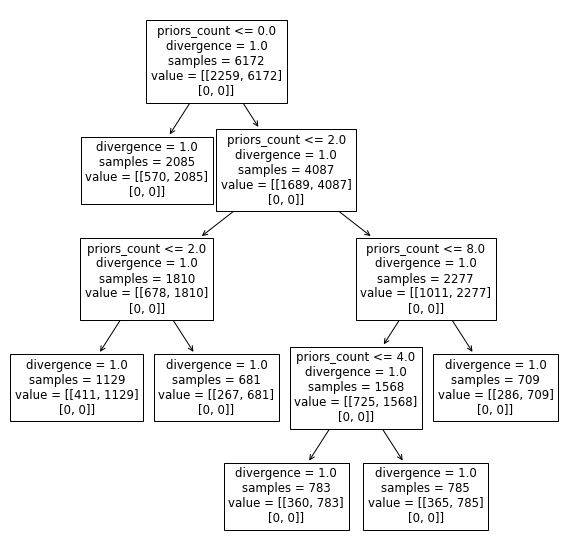

In [413]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.subplots(figsize = (10,10))
tree.plot_tree(clf, feature_names=['priors_count'], precision = 0)
plt.show()

# Generalized

In [392]:
from divexplorer_generalized.FP_Divergence import FP_Divergence

In [393]:
discretizations

{'priors_count': {'<=0': {'rels': ['<='], 'vals': [0]},
  '1': {'rels': ['='], 'vals': [1]},
  '2': {'rels': ['='], 'vals': [2]},
  '[3-4]': {'rels': ['>=', '<='], 'vals': [3, 4]},
  '[5-8]': {'rels': ['>=', '<='], 'vals': [5, 8]},
  '>=9': {'rels': ['>='], 'vals': [9]}}}

In [394]:
generalization_dict

{'priors_count': {'[1-2]': '>=1',
  '1': '[1-2]',
  '2': '[1-2]',
  '>=3': '>=1',
  '[3-8]': '>=3',
  '[3-4]': '[3-8]',
  '[5-8]': '[3-8]',
  '>=9': '>=3'}}

In [396]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

min_sup_divergence = 0.05

FP_fm = extract_divergence_generalized(
    dfI[input_attributes+['race']+cols_c],
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=True,
    true_class_name=true_class_name,
    predicted_class_name=pred_class_name,
    class_map=class_map,
    metrics_divergence = ["d_error"],
    FPM_type="fpgrowth",
)
    
fp_divergence_i = FP_Divergence(FP_fm, metric=metric)

/Users/eliana/Projects/dev/hierarchical-subgroup-exploration/utils_hierarchy.py:80: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  X_one_hot_extend[X_one_hot_extend.columns[list(id_cols)]].any(1).astype(int)
/Users/eliana/Projects/dev/hierarchical-subgroup-exploration/utils_hierarchy.py:80: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  X_one_hot_extend[X_one_hot_extend.columns[list(id_cols)]].any(1).astype(int)
/Users/eliana/Projects/dev/hierarchical-subgroup-exploration/utils_hierarchy.py:80: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  X_one_hot_extend[X_one_hot_extend.columns[list(id_cols)]].any(1).astype(int)
/Users/eliana/Projects/dev/hierarchical-subgroup-exploration/utils_hierarchy.py:80: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.a

In [397]:
fp_divergence_i.getDivergence(th_redundancy=0).sort_values(
        [fp_divergence_i.metric, fp_divergence_i.t_value_col], ascending=False
    )

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
21,0.099482,"(race=Caucasian, priors_count=>=3)",227,27,260,100,2,614.0,0.467427,0.101419,4.832124
16,0.127187,(priors_count=[5-8]),249,45,320,171,1,785.0,0.464968,0.098960,5.267397
26,0.077933,"(priors_count=[3-8], race=Caucasian)",200,20,203,58,2,481.0,0.463617,0.097610,4.161383
8,0.254051,(priors_count=[3-8]),558,83,642,285,1,1568.0,0.462372,0.096365,6.886755
17,0.126863,(priors_count=[3-4]),309,38,322,114,1,783.0,0.459770,0.093762,4.989388
27,0.069994,"(priors_count=[3-4], race=African-American)",156,26,171,79,2,432.0,0.456019,0.090011,3.657217
12,0.150356,"(priors_count=[3-8], race=African-American)",303,57,359,209,2,928.0,0.448276,0.082268,4.728145
4,0.368924,(priors_count=>=3),664,149,862,602,1,2277.0,0.444005,0.077997,6.458767
25,0.080363,"(priors_count=[5-8], race=African-American)",147,31,188,130,2,496.0,0.441532,0.075524,3.283359
9,0.236714,"(priors_count=>=3, race=African-American)",371,113,508,469,2,1461.0,0.425051,0.059044,4.132759


# Convert

In [398]:
generalization_dict

{'priors_count': {'[1-2]': '>=1',
  '1': '[1-2]',
  '2': '[1-2]',
  '>=3': '>=1',
  '[3-8]': '>=3',
  '[3-4]': '[3-8]',
  '[5-8]': '[3-8]',
  '>=9': '>=3'}}

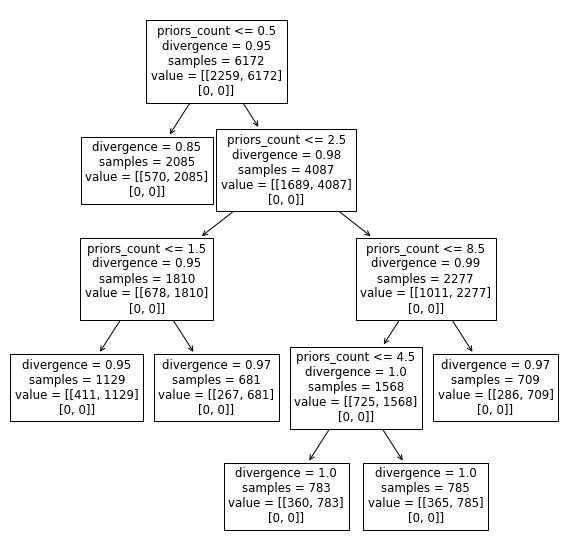

In [414]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.subplots(figsize = (10,10))
tree.plot_tree(clf, feature_names=['priors_count'], precision = 2)
plt.show()

In [415]:
import sklearn
print(sklearn.tree.export_text(clf, feature_names=['priors']))

|--- priors <= 0.50
|   |--- value: [570.00, 0.00]
|--- priors >  0.50
|   |--- priors <= 2.50
|   |   |--- priors <= 1.50
|   |   |   |--- value: [411.00, 0.00]
|   |   |--- priors >  1.50
|   |   |   |--- value: [267.00, 0.00]
|   |--- priors >  2.50
|   |   |--- priors <= 8.50
|   |   |   |--- priors <= 4.50
|   |   |   |   |--- value: [360.00, 0.00]
|   |   |   |--- priors >  4.50
|   |   |   |   |--- value: [365.00, 0.00]
|   |   |--- priors >  8.50
|   |   |   |--- value: [286.00, 0.00]



In [402]:
attr = "root"
val = ""
rel = ""

dataset_len = X.shape[0]



node_divergence = -1
node_size = clftree.n_node_samples[0]
support = clftree.n_node_samples[0] / dataset_len
    
confusion_matrix = None
node_criterion = clftree.impurity[0]
node_support_ratio = node_size / parent_size
    
        


In [403]:
tree1 = tree_discr.trees['priors_count']



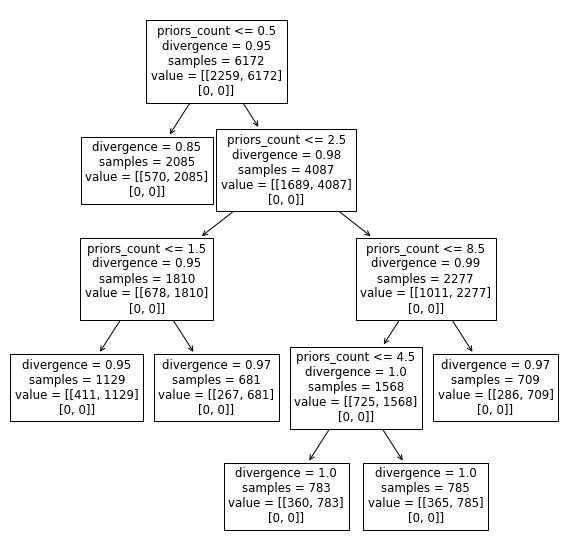

In [405]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.subplots(figsize = (10,10))
tree.plot_tree(clf, feature_names=['priors_count'], precision = 2)
plt.show()

In [421]:
from utils_sklearn_convert import build_tree

In [442]:
clftree = clf.tree_

mytree = build_tree(clftree, 'prior', is_integer=True, verbose=True)

|--- root   s: 1.00 Impurity: 0.95 Size_ratio: 1.00 	div 0.00
|   |--- prior <= 0.00 s: 0.34 Impurity: 0.85 Size_ratio: 0.34 	div -0.09
|   |--- prior > 0.00 s: 0.66 Impurity: 0.98 Size_ratio: 0.66 	div 0.05
|   |   |--- prior <= 2.00 s: 0.29 Impurity: 0.95 Size_ratio: 0.44 	div 0.01
|   |   |   |--- prior <= 1.00 s: 0.18 Impurity: 0.95 Size_ratio: 0.62 	div -0.00
|   |   |   |--- prior > 1.00 s: 0.11 Impurity: 0.97 Size_ratio: 0.38 	div 0.03
|   |   |--- prior > 2.00 s: 0.37 Impurity: 0.99 Size_ratio: 0.56 	div 0.08
|   |   |   |--- prior <= 8.00 s: 0.25 Impurity: 1.00 Size_ratio: 0.69 	div 0.10
|   |   |   |   |--- prior <= 4.00 s: 0.13 Impurity: 1.00 Size_ratio: 0.50 	div 0.09
|   |   |   |   |--- prior > 4.00 s: 0.13 Impurity: 1.00 Size_ratio: 0.50 	div 0.10
|   |   |   |--- prior > 8.00 s: 0.11 Impurity: 0.97 Size_ratio: 0.31 	div 0.04


In [443]:
td.printTree(tree = mytree, round_v =2, show_condition = True)

 root s=1.00 --> None=0.00
         prior<=0 s=0.34 --> None=-0.09
         prior>0 s=0.66 --> None=0.05
                 prior<=2 s=0.29 --> None=0.01
                         prior<=1 s=0.18 --> None=-0.00
                         prior>1 s=0.11 --> None=0.03
                 prior>2 s=0.37 --> None=0.08
                         prior<=8 s=0.25 --> None=0.10
                                 prior<=4 s=0.13 --> None=0.09
                                 prior>4 s=0.13 --> None=0.10
                         prior>8 s=0.11 --> None=0.04


In [444]:
tree1 = tree_discr.trees['priors_count']

tree1.printTree(tree = tree1.tree, round_v =2, show_condition = True)

 root s=1.00 --> d_error=0.00
         priors_count<=0 s=0.34 --> d_error=-0.09
         priors_count>0 s=0.66 --> d_error=0.05
                 priors_count<=2 s=0.29 --> d_error=0.01
                         priors_count<=1 s=0.18 --> d_error=-0.00
                         priors_count>1 s=0.11 --> d_error=0.03
                 priors_count>2 s=0.37 --> d_error=0.08
                         priors_count<=8 s=0.25 --> d_error=0.10
                                 priors_count<=4 s=0.13 --> d_error=0.09
                                 priors_count>4 s=0.13 --> d_error=0.10
                         priors_count>8 s=0.11 --> d_error=0.04


In [447]:
from TreeDivergence import TreeDivergence

td = TreeDivergence()

td.get_hierarchy_DF(mytree, ver2=True)

,attribute,itemset_name,parent_node_name,parent_node_name_all_attrs,rels,vals,level
0,prior,<=0,(),"[(root, {})]",[<=],[0],0
1,prior,>0,(),"[(root, {})]",[>],[0],0
2,prior,[0-2],>0,"[(root, {}), (prior, >0)]","[>, <=]","[0, 2]",1
3,prior,[0-1],[0-2],"[(root, {}), (prior, [0-2])]","[>, <=]","[0, 1]",2
4,prior,[1-2],[0-2],"[(root, {}), (prior, [0-2])]","[>, <=]","[1, 2]",2
5,prior,>2,>0,"[(root, {}), (prior, >0)]",[>],[2],1
6,prior,[2-8],>2,"[(root, {}), (prior, >2)]","[>, <=]","[2, 8]",2
7,prior,[2-4],[2-8],"[(root, {}), (prior, [2-8])]","[>, <=]","[2, 4]",3
8,prior,[4-8],[2-8],"[(root, {}), (prior, [2-8])]","[>, <=]","[4, 8]",3
9,prior,>8,>2,"[(root, {}), (prior, >2)]",[>],[8],2


In [449]:
from TreeDivergence import TreeDivergence

td = TreeDivergence()

td.get_hierarchy_DF(tree1.tree, ver2=False)

,attribute,itemset_name,parent_node_name,parent_node_name_all_attrs,rels,vals,level
0,priors_count,<=0,(),"[(root, {})]",[<=],[0],0
1,priors_count,>=1,(),"[(root, {})]",[>=],[1],0
2,priors_count,[1-2],>=1,"[(root, {}), (priors_count, >=1)]","[>=, <=]","[1, 2]",1
3,priors_count,1,[1-2],"[(root, {}), (priors_count, [1-2])]",[=],[1],2
4,priors_count,2,[1-2],"[(root, {}), (priors_count, [1-2])]",[=],[2],2
5,priors_count,>=3,>=1,"[(root, {}), (priors_count, >=1)]",[>=],[3],1
6,priors_count,[3-8],>=3,"[(root, {}), (priors_count, >=3)]","[>=, <=]","[3, 8]",2
7,priors_count,[3-4],[3-8],"[(root, {}), (priors_count, [3-8])]","[>=, <=]","[3, 4]",3
8,priors_count,[5-8],[3-8],"[(root, {}), (priors_count, [3-8])]","[>=, <=]","[5, 8]",3
9,priors_count,>=9,>=3,"[(root, {}), (priors_count, >=3)]",[>=],[9],2


In [450]:
import sklearn
print(sklearn.tree.export_text(clf, feature_names=['priors']))

|--- priors <= 0.50
|   |--- value: [570.00, 0.00]
|--- priors >  0.50
|   |--- priors <= 2.50
|   |   |--- priors <= 1.50
|   |   |   |--- value: [411.00, 0.00]
|   |   |--- priors >  1.50
|   |   |   |--- value: [267.00, 0.00]
|   |--- priors >  2.50
|   |   |--- priors <= 8.50
|   |   |   |--- priors <= 4.50
|   |   |   |   |--- value: [360.00, 0.00]
|   |   |   |--- priors >  4.50
|   |   |   |   |--- value: [365.00, 0.00]
|   |   |--- priors >  8.50
|   |   |   |--- value: [286.00, 0.00]



In [451]:
from TreeDivergence import TreeDivergence

td = TreeDivergence()

td.getHierarchyAndDiscretizationSplits(tree1.tree, ver2=False)



({'priors_count': {'[1-2]': '>=1',
   '1': '[1-2]',
   '2': '[1-2]',
   '>=3': '>=1',
   '[3-8]': '>=3',
   '[3-4]': '[3-8]',
   '[5-8]': '[3-8]',
   '>=9': '>=3'}},
 {'priors_count': {'<=0': {'rels': ['<='], 'vals': [0]},
   '1': {'rels': ['='], 'vals': [1]},
   '2': {'rels': ['='], 'vals': [2]},
   '[3-4]': {'rels': ['>=', '<='], 'vals': [3, 4]},
   '[5-8]': {'rels': ['>=', '<='], 'vals': [5, 8]},
   '>=9': {'rels': ['>='], 'vals': [9]}}})

In [455]:
from TreeDivergence import TreeDivergence

td = TreeDivergence()

td.getHierarchyAndDiscretizationSplits(mytree, ver2=True)



prior >


ValueError: # TODO - only intervals